<a href="https://colab.research.google.com/github/AnnaPakir/Multiclass-classification-of-posters/blob/main/Posters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Многоклассовая классификация фильмов по жанрам

**Описание проекта:**
Данный проект создан для проверки гипотезы возможности установить зависмость постеров к фильму от жанра фильма.</b>



**Цель исследования:**  создать нейронную сеть для проверки гипотезы, превести обучение.</b>

**Используемые технологии:** библиотека Keras, сверточная нейронная сеть ResNet50.

Загрузим данные из Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matveevaanna","key":"a2058e1779e6368af4bf83290fa5c1ed"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gsimonx37/letterboxd

100% 21.3G/21.3G [04:32<00:00, 184MB/s]
100% 21.3G/21.3G [04:33<00:00, 83.7MB/s]


In [ ]:
! unzip letterboxd.zip -d letterboxd

  inflating: letterboxd/posters/1883123.jpg  
  inflating: letterboxd/posters/1883132.jpg  
  inflating: letterboxd/posters/1883133.jpg  
  inflating: letterboxd/posters/1883144.jpg  
  inflating: letterboxd/posters/1883145.jpg  
  inflating: letterboxd/posters/1883146.jpg  
  inflating: letterboxd/posters/1883148.jpg  
  inflating: letterboxd/posters/1896388.jpg  
  inflating: letterboxd/posters/1896391.jpg  
  inflating: letterboxd/posters/1896392.jpg  
  inflating: letterboxd/releases.csv  
  inflating: letterboxd/studios.csv  
  inflating: letterboxd/themes.csv   


Загрузим необходмые библиотеки

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image
from tqdm import tqdm

Загрузим данные

In [ ]:
df_genres = pd.read_csv('letterboxd/genres.csv', sep=',')

In [ ]:
df_genres.head()

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller


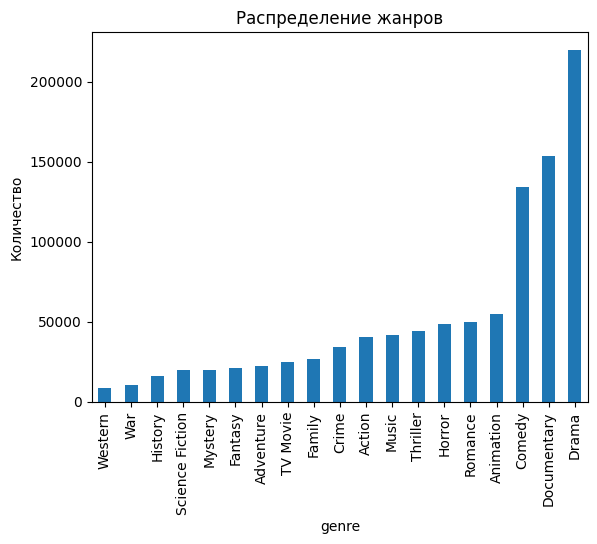

In [ ]:
df_genres.pivot_table(index='genre', values='id', aggfunc='count').sort_values(by='id').plot(kind='bar', legend = False)
plt.title('Распределение жанров')
plt.ylabel('Количество')
plt.show()

Для корректного обучения модели необходимо чтобы одному фильму(постеру) соответсвовал один жанр. Также для обучения моделей лучше избавиться от жанров с небольшим представительством. Для этого можно сделать:
- объединение похожих жанров.
- выделение главных жанров в кадом фильме

In [ ]:
df_genres['genre']= df_genres['genre'].replace(['War','Thriller','Crime','Action'], 'Weapon')
df_genres['genre']= df_genres['genre'].replace(['Western', 'TV Movie', 'Science Fiction'], 'History')
df_genres['genre']= df_genres['genre'].replace(['Mystery','Horror'], 'Fantasy')
df_genres['genre']= df_genres['genre'].replace(['Romance','Adventure', 'Music'], 'Family')

In [ ]:
df_genres.duplicated().sum()

46052

In [ ]:
df_genres= df_genres.drop_duplicates()

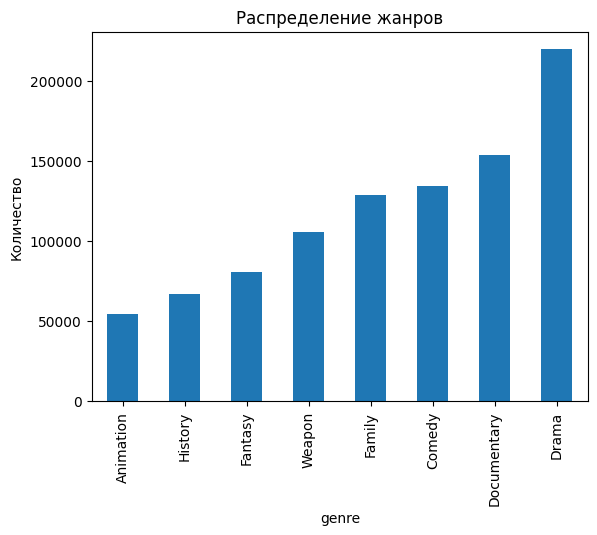

In [ ]:
df_genres.pivot_table(index='genre', values='id', aggfunc='count').sort_values(by='id').plot(kind='bar', legend = False)
plt.title('Распределение жанров')
plt.ylabel('Количество')
plt.show()

In [ ]:
len(df_genres['id'].unique())  # количество фильмов

638632

In [ ]:
def eliminate(df, genre):
  count_genre = df.pivot_table(index= 'id', values = 'genre', aggfunc= 'count').reset_index()
  count_genre.columns= ['id','count']
  df_total = df.merge(right =count_genre, on ='id', how='left' )
  df_one = df_total[df_total['count']==1]
  df_total = df_total[df_total['count']>1]
  df_total = df_total[df_total['genre']!=genre]
  df = pd.concat([df_one,df_total])
  df = df.drop('count', axis =1)
  count_genre = df.pivot_table(index= 'id', values = 'genre', aggfunc= 'count').reset_index()
  count_genre.columns= ['id','count']
  print(count_genre['count'].value_counts())
  print('Количество фильмов: ', len(df['id'].unique()))
  return df

In [ ]:
df_genres = eliminate(df_genres, ' ')

1    402559
2    175815
3     51601
4      7696
5       838
6       110
7        12
8         1
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Drama')

1    485737
2    122896
3     25898
4      3622
5       427
6        51
7         1
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Documentary')

1    508849
2    102491
3     23428
4      3411
5       413
6        40
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Comedy')

1    554608
2     69370
3     12970
4      1572
5       112
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Family')

1    586599
2     45952
3      5830
4       251
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'History')

1    606978
2     30666
3       988
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Weapon')

1    632733
2      5899
Name: count, dtype: int64
Количество фильмов:  638632


In [ ]:
df_genres = eliminate(df_genres, 'Fantasy')

1    638632
Name: count, dtype: int64
Количество фильмов:  638632


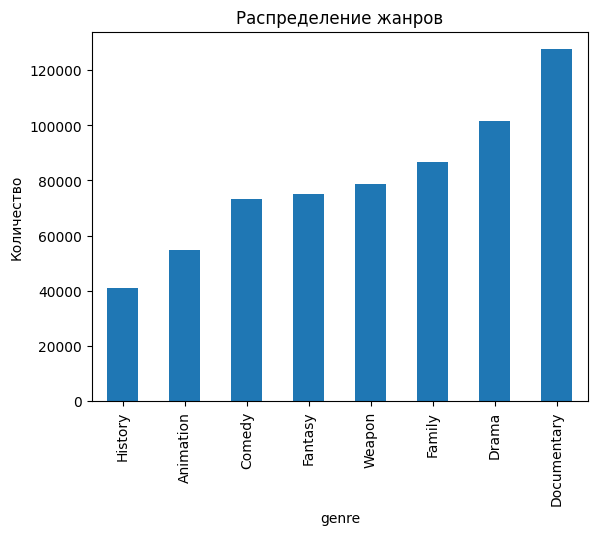

In [ ]:
df_genres.pivot_table(index='genre', values='id', aggfunc='count').sort_values(by='id').plot(kind='bar', legend = False)
plt.title('Распределение жанров')
plt.ylabel('Количество')
plt.show()

In [ ]:
df_2 = df_genres.sample(n=15000, random_state=42)  # случайшая выборка

In [ ]:
df_2['id']= df_2['id'].apply(lambda x: str(x)+'.jpg')

Есть фильмы, постеры к которым либо отсутствуют, либо по какой-то причине не открываются. Они будут удалены.

In [ ]:
def not_error(line):
  if os.path.exists('letterboxd/posters/'+line['id']):
    return 'yes'
  else:
    return 'no'


In [ ]:
for i in tqdm(range(100)):
    df_2['not_error'] = df_2.apply(not_error, axis =1)

100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


In [ ]:
df_2['not_error'].value_counts()

yes    13012
no      1988
Name: not_error, dtype: int64

In [ ]:
df_2 = df_2[df_2['not_error']=='yes']
df_2 = df_2.drop('not_error', axis =1)

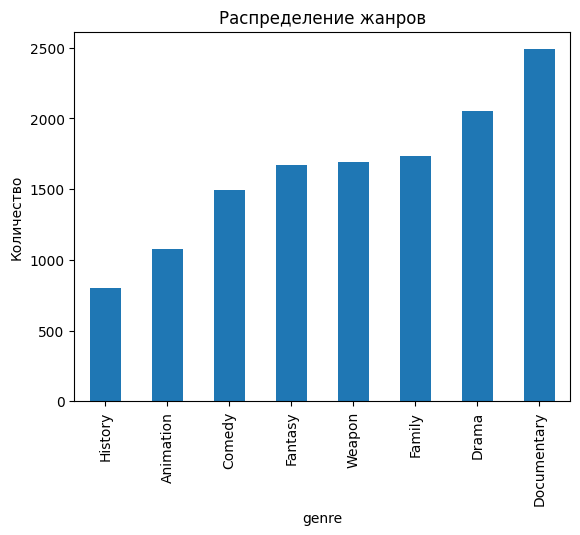

In [ ]:
df_2.pivot_table(index='genre', values='id', aggfunc='count').sort_values(by='id').plot(kind='bar', legend = False)
plt.title('Распределение жанров')
plt.ylabel('Количество')
plt.show()

Посмотрим на постеры

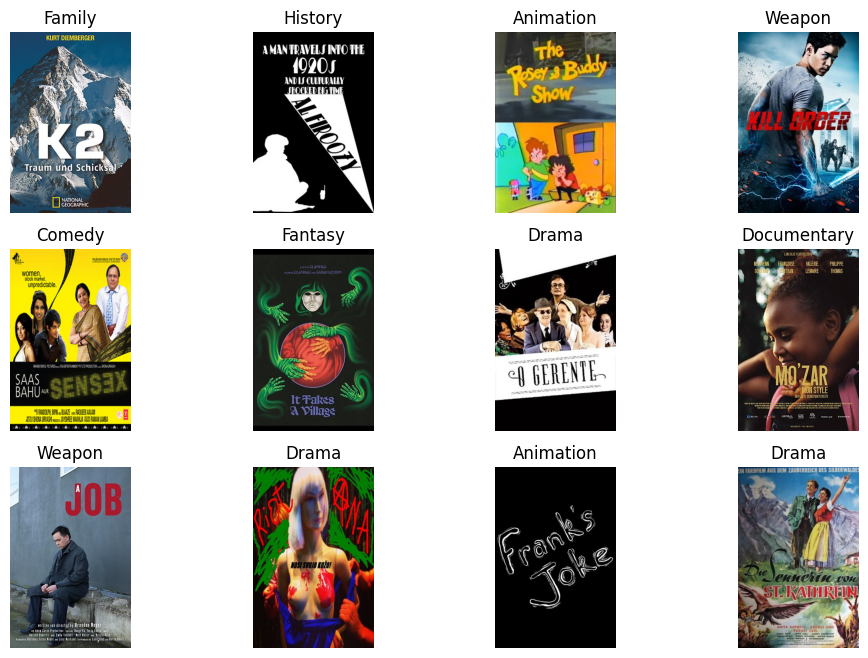

In [ ]:
fig = plt.figure(figsize=(12,8))
for e in range(12):
    plt.subplot(3,4,e+1)
    plt.imshow(Image.open('letterboxd/posters/'+df_2['id'].loc[df_2.index[e]]), cmap=plt.get_cmap('gray'))
    plt.title(df_2['genre'].loc[df_2.index[e]])
    plt.xticks([])
    plt.axis('off')

In [ ]:
datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df_2,
        directory='letterboxd/posters/',
        x_col='id',
        y_col='genre',
        target_size=(224, 224),
        batch_size=16,
        subset='training',
        class_mode='categorical',
        seed=12345)
val_gen_flow = datagen.flow_from_dataframe(
        dataframe=df_2,
        directory='letterboxd/posters/',
        x_col='id',
        y_col='genre',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        seed=12345)

Found 9759 validated image filenames belonging to 8 classes.
Found 3253 validated image filenames belonging to 8 classes.


In [ ]:
optimizer = Adam(learning_rate=0.001)

In [ ]:
backbone = ResNet50(input_shape=None,
                        weights='imagenet',
                        include_top=False)

model = Sequential()

model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.compile(optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'],
                  loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 24

In [ ]:
models = model.fit(train_gen_flow, epochs =15,
          validation_data=val_gen_flow,
          steps_per_epoch=len(train_gen_flow),
          validation_steps=len(val_gen_flow))

Epoch 1/15
610/610 [==============================] - 166s 218ms/step - loss: 2.2583 - accuracy: 0.1708 - val_loss: 2.0281 - val_accuracy: 0.1937
Epoch 2/15
610/610 [==============================] - 139s 228ms/step - loss: 2.0261 - accuracy: 0.1991 - val_loss: 2.0241 - val_accuracy: 0.1940
Epoch 3/15
610/610 [==============================] - 130s 213ms/step - loss: 2.0001 - accuracy: 0.2151 - val_loss: 1.9829 - val_accuracy: 0.2263
Epoch 4/15
610/610 [==============================] - 130s 213ms/step - loss: 1.9936 - accuracy: 0.2246 - val_loss: 1.9721 - val_accuracy: 0.2398
Epoch 5/15
610/610 [==============================] - 139s 227ms/step - loss: 1.9737 - accuracy: 0.2411 - val_loss: 2.0483 - val_accuracy: 0.1961
Epoch 6/15
610/610 [==============================] - 139s 227ms/step - loss: 1.9847 - accuracy: 0.2314 - val_loss: 1.9636 - val_accuracy: 0.2309
Epoch 7/15
610/610 [==============================] - 139s 228ms/step - loss: 1.9597 - accuracy: 0.2456 - val_loss: 1.9545 -

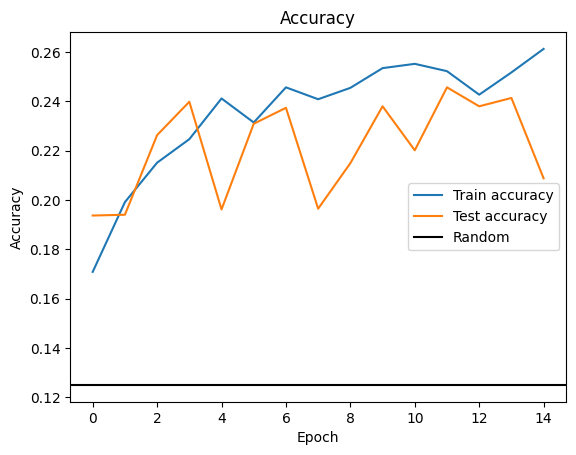

In [ ]:
plt.plot(models.history['accuracy'], label='Train accuracy')
plt.plot(models.history['val_accuracy'], label='Test accuracy')
plt.axhline(1/8, color = 'black', label = 'Random')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Вывод:** В данном проекте была создана нейронная сеть для коассификации постеров к фильмам по жанрам. В процессе работы были объединены редковстречающиеся жанры с похожими, а также проведена другая предобработка данных. Случайным образом были выбраны 15 000 постеров для обучения сети. Итоговая метрика accyracy стабильно выше случайных значений, как на тестовой, так и на тренировочной выборке. Метрика на тренировочной выбооке растет, а на тестовой находится между 0.20 и 0.24. Результат говорит о том, что увеличение эпох на не влияет на качество предсказания на тестовой выборке, в отношении тренировочной выборки заметно переобучение. Таким образом, с помощью нейронной сети жанры по постерам определяются, но для уведичения метрик необходимо больший объем данных.  